## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificate

In [2]:
def show(*images):
    plt.gray()
    if len(images) == 1:
        plt.axis('off')
        plt.imshow(images[0])
        plt.show()
        return
    
    fig, ax = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for image, axis in zip(images, ax):
        axis.axis('off')
        axis.imshow(image)
    plt.show()

In [3]:
def inverse_fft(f_image):
    f_unshifted_image = np.fft.ifftshift(f_image, [0, 1])

    inverse_image = cv2.idft(f_unshifted_image, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    inverse_image = cv2.magnitude(inverse_image[:, :, 0], inverse_image[:, :, 1])
    inverse_image = np.round(inverse_image).astype('uint8')
    
    return inverse_image

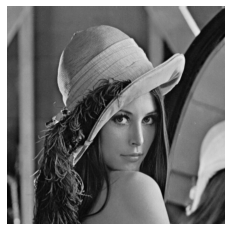

In [4]:
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
show(lena)

1. Zdefiniuj rozmiar filtra (np. 21).

In [5]:
filter_size = 21

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

In [6]:
hamming = np.hamming(filter_size)

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

In [7]:
hamming2d = np.outer(hamming, hamming)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

In [8]:
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(filter_size))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, filter_size]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(filter_size))
FSpaceColsM = np.outer(np.ones([1, filter_size]), FSpaceCols)

FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

FilterF = FreqR <= 0.1

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

In [9]:
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),
                 flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

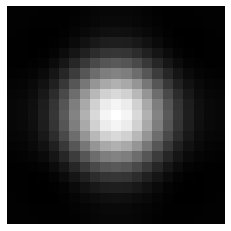

In [10]:
new_filter = FilterFI * hamming2d
show(new_filter)

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

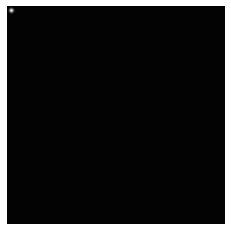

In [11]:
filter_with_border = cv2.copyMakeBorder(new_filter, 0, lena.shape[0] - new_filter.shape[0], 0, lena.shape[1] - new_filter.shape[1], cv2.BORDER_CONSTANT, value=0)
show(filter_with_border)

In [12]:
f_filter = np.fft.fftshift(cv2.dft(filter_with_border.astype(float), flags=cv2.DFT_COMPLEX_OUTPUT), [0, 1])
f_filter = cv2.magnitude(f_filter[:, :, 0], f_filter[:, :, 1])
f_filter = np.repeat(f_filter[:, :, np.newaxis], 2, axis=2)

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [13]:
f_lena = np.fft.fftshift(cv2.dft(lena.astype(float), flags=cv2.DFT_COMPLEX_OUTPUT), [0, 1])

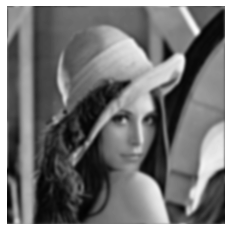

In [14]:
lena_filtered = f_lena * f_filter
lena_fft = inverse_fft(lena_filtered)

show(lena_fft)

<ipython-input-15-88b7daf83f9b>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


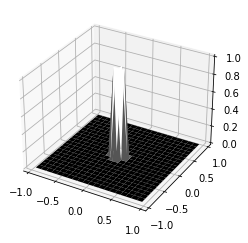

In [15]:
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, FilterF, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()